# Image Classification using a Convolutional Neural Network

# 1. Install Dependencies

In [ ]:
!python3 -m pip install tensorflow matplotlib opencv-python

In [ ]:
import tensorflow as tf
import numpy as np
import functools
from matplotlib import pyplot as plt

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
gpus

# 2. Set Up Data

## 2.1. Clean Up Data

In [5]:
import cv2
import imghdr

In [37]:
IMAGES_DIR = 'data'
IMAGE_EXTENSIONS = ['jpeg', 'jpg', 'png', 'bmp']

# Delete all the images that are not supported.
for image_class in os.listdir(IMAGES_DIR):
    for file_name in os.listdir(os.path.join(IMAGES_DIR, image_class)):
        file_path = os.path.join(IMAGES_DIR, image_class, file_name)
        try:
            image = cv2.imread(file_path) # load the image
            extension = imghdr.what(file_path) # get the extension of the image
            if extension not in IMAGE_EXTENSIONS:
                print('Image extension is not supported: {}'.format(file_path))
                os.remove(file_path)
        except Exception as e:
            print('Failed to load, get extension, or remove image: {}'.format(file_path)) 

In [38]:
# list out images
os.listdir(os.path.join(IMAGES_DIR, 'man'))
os.listdir(os.path.join(IMAGES_DIR, 'woman'))

['167407.jpg.jpg',
 '182500.jpg.jpg',
 '149896.jpg.jpg',
 '166253.jpg.jpg',
 '161118.jpg.jpg',
 '151134.jpg.jpg',
 '138994.jpg.jpg',
 '117380.jpg.jpg',
 '156799.jpg.jpg',
 '137939.jpg.jpg',
 '127472.jpg.jpg',
 '131027.jpg.jpg',
 '113513.jpg.jpg',
 '178452.jpg.jpg',
 '129410.jpg.jpg',
 '201761.jpg.jpg',
 '170753.jpg.jpg',
 '132637.jpg.jpg',
 '146722.jpg.jpg',
 '189966.jpg.jpg',
 '146163.jpg.jpg',
 '141529.jpg.jpg',
 '113166.jpg.jpg',
 '137426.jpg.jpg',
 '172823.jpg.jpg',
 '131365.jpg.jpg',
 '199793.jpg.jpg',
 '150241.jpg.jpg',
 '139248.jpg.jpg',
 '190406.jpg.jpg',
 '199043.jpg.jpg',
 '151434.jpg.jpg',
 '120700.jpg.jpg',
 '137583.jpg.jpg',
 '153298.jpg.jpg',
 '118963.jpg.jpg',
 '145052.jpg.jpg',
 '181443.jpg.jpg',
 '157637.jpg.jpg',
 '194174.jpg.jpg',
 '176578.jpg.jpg',
 '183471.jpg.jpg',
 '170126.jpg.jpg',
 '161089.jpg.jpg',
 '113933.jpg.jpg',
 '152914.jpg.jpg',
 '179677.jpg.jpg',
 '159992.jpg.jpg',
 '140974.jpg.jpg',
 '154420.jpg.jpg',
 '200725.jpg.jpg',
 '120443.jpg.jpg',
 '162730.jpg

(127, 105, 3)


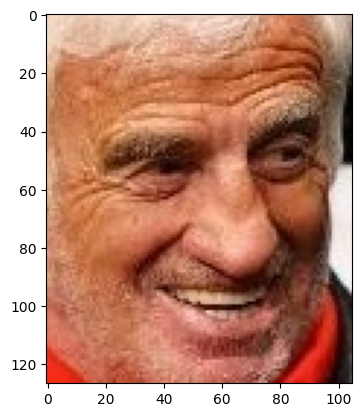

In [39]:
# sample image
img = cv2.imread(os.path.join(IMAGES_DIR, 'man', '087812.jpg.jpg'))
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## 2.2. Load Data

In [40]:
BATCH_SIZE = 32
IMAGE_SIZE = (100, 100)

In [41]:
# create a tf.data.Dataset from our images
images_data = tf.keras.utils.image_dataset_from_directory(IMAGES_DIR, batch_size = BATCH_SIZE, image_size=IMAGE_SIZE)

Found 58658 files belonging to 2 classes.


2023-04-10 14:26:01.213239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [58658]
	 [[{{node Placeholder/_4}}]]
2023-04-10 14:26:01.213529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [58658]
	 [[{{node Placeholder/_4}}]]


(32, 100, 100, 3)
(32,)


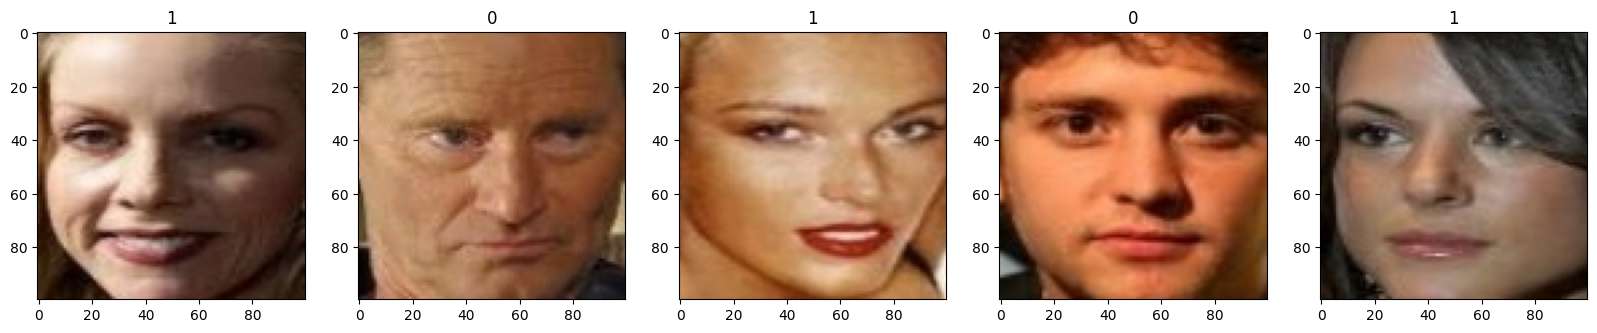

In [42]:
# -- viewing some of the data --
# create an iterator from the dataset
images_data_iterator = images_data.as_numpy_iterator()

# get the first batch
batch = images_data_iterator.next()
print(batch[0].shape)
print(batch[1].shape)
# batch is a tuple with size 2, the first one being `BATCH_SIZE` images and the second one being `BATCH_SIZE` labels

# sample of 5 images and their labels
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int)) # img is in RGB [0, 255] but with floats; need to make it with ints
    ax[idx].title.set_text(batch[1][idx])

## 2.3. Preprocessing

In [43]:
# scale the images to [0,1]
images_data = images_data.map(lambda x, y: (x/255, y)) # x is an image, y is a label

In [44]:
print("data size: ", len(images_data))
# set the data sizes
train_size = int(len(images_data) * 0.8)
test_size = int(len(images_data) * 0.1)
validation_size = int(len(images_data) * 0.1) + 1
assert(train_size + test_size + validation_size == len(images_data))

data size:  1834


In [45]:
# create the datasets 
train = images_data.take(train_size)
validation = images_data.skip(train_size).take(validation_size)
test = images_data.skip(train_size+validation_size).take(test_size)

# 3. Convolutional Neural Network

## 3.1 Build CNN Model

In [71]:
# defining the model
def make_CNN_classifier(n_filters=16, n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, activation='relu')
  MaxPool2D = tf.keras.layers.MaxPool2D
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([ 
    Conv2D(filters=1*n_filters, kernel_size=(3,3),  strides=1, input_shape=(100, 100, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001), padding="valid"),
    MaxPool2D(pool_size=(2,2)),
    
    Conv2D(filters=2*n_filters, kernel_size=(3,3),  strides=1),
    MaxPool2D(pool_size=(2,2)),
      
#     Conv2D(filters=2*n_filters, kernel_size=(3,3),  strides=1),
#     MaxPool2D(pool_size=(2,2)),

    Conv2D(filters=4*n_filters, kernel_size=(3,3),  strides=1),
    MaxPool2D(pool_size=(2,2)),
      
#     Conv2D(filters=4*n_filters, kernel_size=(3,3),  strides=1),
#     MaxPool2D(pool_size=(2,2)),

    Flatten(),
      
    Dense(256),
    Dense(n_outputs, activation='sigmoid'),
  ])
  return model

CNN_model = make_CNN_classifier(n_filters=32, n_outputs=1)

In [49]:
# compiling the model
CNN_model.compile(optimizer='rmsprop', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
CNN_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 10, 10, 128)     

## 3.2 Train CNN Model

In [50]:
LOGS_DIR='logs'
# log information while training
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOGS_DIR)

In [51]:
NUM_EPOCH = 15
STEPS_PER_EPOCH = 96
VALIDATION_STEPS=50

history = CNN_model.fit(train, steps_per_epoch=STEPS_PER_EPOCH, epochs=NUM_EPOCH, validation_data=validation, validation_steps=VALIDATION_STEPS)

Epoch 1/15


2023-04-10 14:26:28.062055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [58658]
	 [[{{node Placeholder/_4}}]]
2023-04-10 14:26:28.062309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [58658]
	 [[{{node Placeholder/_4}}]]


93/96 [============================>.] - ETA: 0s - loss: 0.6896 - accuracy: 0.5931

2023-04-10 14:26:30.839662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [58658]
	 [[{{node Placeholder/_4}}]]
2023-04-10 14:26:30.839919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [58658]
	 [[{{node Placeholder/_4}}]]


96/96 [==============================] - 5s 38ms/step - loss: 0.6871 - accuracy: 0.5970 - val_loss: 0.5235 - val_accuracy: 0.7681
Epoch 2/15
96/96 [==============================] - 4s 38ms/step - loss: 0.4922 - accuracy: 0.7816 - val_loss: 0.3681 - val_accuracy: 0.8531
Epoch 3/15
96/96 [==============================] - 4s 39ms/step - loss: 0.3756 - accuracy: 0.8372 - val_loss: 0.3211 - val_accuracy: 0.8731
Epoch 4/15
96/96 [==============================] - 4s 39ms/step - loss: 0.3186 - accuracy: 0.8708 - val_loss: 0.2429 - val_accuracy: 0.9137
Epoch 5/15
96/96 [==============================] - 4s 39ms/step - loss: 0.2535 - accuracy: 0.9017 - val_loss: 0.2969 - val_accuracy: 0.8763
Epoch 6/15
96/96 [==============================] - 4s 38ms/step - loss: 0.2173 - accuracy: 0.9206 - val_loss: 0.2161 - val_accuracy: 0.9162
Epoch 7/15
96/96 [==============================] - 4s 38ms/step - loss: 0.2191 - accuracy: 0.9150 - val_loss: 0.2207 - val_accuracy: 0.9225
Epoch 8/15
96/96 [======

In [52]:
# print the history of metrics throughout training
history.history

{'loss': [0.6870535016059875,
  0.4921838343143463,
  0.375561386346817,
  0.3186343312263489,
  0.25352057814598083,
  0.21729089319705963,
  0.21906155347824097,
  0.20248545706272125,
  0.19245727360248566,
  0.19318018853664398,
  0.16300930082798004,
  0.16776125133037567,
  0.17772741615772247,
  0.14167004823684692,
  0.176790252327919],
 'accuracy': [0.5970051884651184,
  0.7815755009651184,
  0.8372395634651184,
  0.8707682490348816,
  0.9016926884651184,
  0.9205729365348816,
  0.9150390625,
  0.9267578125,
  0.9300130009651184,
  0.9248046875,
  0.9381510615348816,
  0.9391276240348816,
  0.9339192509651184,
  0.951171875,
  0.9313151240348816],
 'val_loss': [0.5235303044319153,
  0.3680651783943176,
  0.32109421491622925,
  0.2429429292678833,
  0.29690834879875183,
  0.21611624956130981,
  0.22069235146045685,
  0.37852489948272705,
  0.19112330675125122,
  0.25389960408210754,
  0.1679084748029709,
  0.18494504690170288,
  0.1606067270040512,
  0.16753007471561432,
  0.16

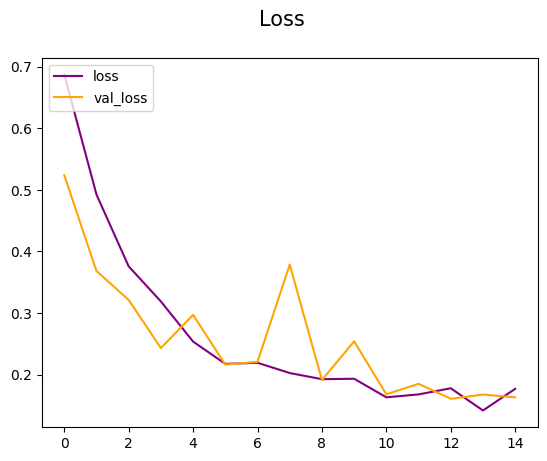

In [53]:
# plot loss
fig = plt.figure()
plt.plot(history.history['loss'], color='purple', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=15)
plt.legend(loc='upper left')
plt.show()

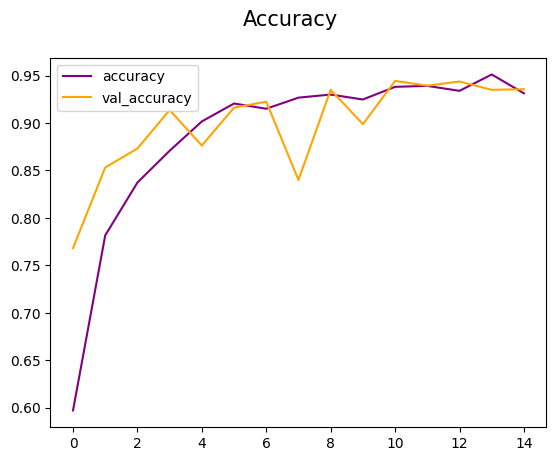

In [54]:
# plot accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='purple', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=15)
plt.legend(loc='upper left')
plt.show()

# 4. Evaluation

## 4.1 Evaluation Metrics

In [55]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [207]:
for batch in test.as_numpy_iterator():
    x, y = batch
    y_hat = CNN_model.predict(x)
    precision.update_state(y, y_hat)
    recall.update_state(y, y_hat)
    accuracy.update_state(y, y_hat)

2023-04-09 22:35:20.691320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [58658]
	 [[{{node Placeholder/_4}}]]
2023-04-09 22:35:20.691587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [58658]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 264ms/step


In [208]:
print(f'Precision: {precision.result()}\nRecall: {recall.result()}\nResult: {accuracy.result()}')

Precision: 0.9609017372131348
Recall: 0.9332877397537231
Result: 0.9474768042564392


## 4.2 Manual Testing

### Man

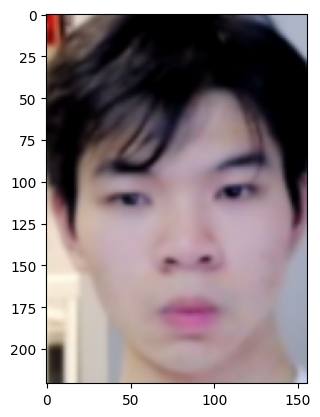

In [56]:
# -- grab test image --
man_img_path = os.path.join('manual', 'man', 'man1.PNG')
test_img = cv2.imread(man_img_path)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show()

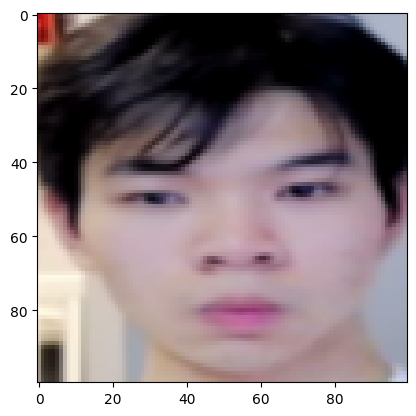

In [57]:
# -- resize and show image --
test_img = tf.image.resize(test_img, IMAGE_SIZE)
# note we must np.uint8 to pass into cvtColor: https://github.com/albumentations-team/albumentations/issues/67
plt.imshow(cv2.cvtColor(test_img.numpy().astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()

In [58]:
y_hat = CNN_model.predict(np.expand_dims(test_img /255, 0))

1/1 [==============================] - 0s 387ms/step


In [59]:
print(y_hat[0][0])
if y_hat[0][0] > 0.5: 
    print(f'Prediction: woman')
else: 
    print(f'Prediction: man')

0.21082753
Prediction: man


### Woman

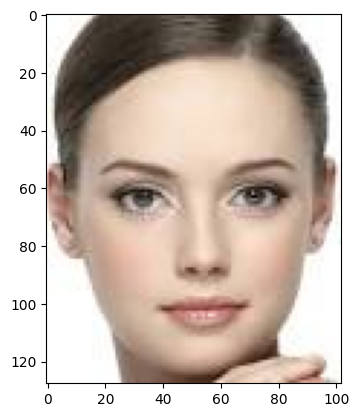

In [87]:
# -- grab test image --
woman_img_path = os.path.join('manual', 'woman', 'woman1.jpg')
test_img = cv2.imread(woman_img_path)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show()

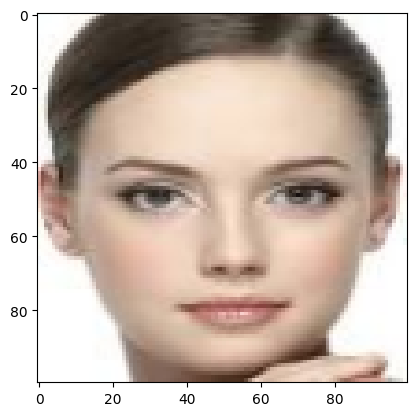

In [88]:
# -- resize and show image --
test_img = tf.image.resize(test_img, IMAGE_SIZE)
# note we must np.uint8 to pass into cvtColor: https://github.com/albumentations-team/albumentations/issues/67
plt.imshow(cv2.cvtColor(test_img.numpy().astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()

In [89]:
y_hat = CNN_model.predict(np.expand_dims(test_img /255, 0))

1/1 [==============================] - 0s 17ms/step


In [90]:
print(y_hat[0][0])
if y_hat[0][0] > 0.5: 
    print(f'Prediction: woman')
else: 
    print(f'Prediction: man')

0.5065568
Prediction: woman


# 5. Save Prameters

In [69]:
# save current model
CNN_model.save(os.path.join('models', 'gender_classification_kaggle_v1.h5'))

# 6. Load Existing Model

In [72]:
loaded_model = tf.keras.models.load_model(os.path.join('models', 'gender_classification_kaggle_v1', 'gender_classification_kaggle_v1.h5'))

In [73]:
y_hat_loaded = loaded_model.predict(np.expand_dims(test_img/255, 0))

1/1 [==============================] - 0s 426ms/step


In [74]:
print(y_hat[0][0])
if y_hat[0][0] > 0.5: 
    print(f'Prediction: woman')
else: 
    print(f'Prediction: man')

0.50357074
Prediction: woman
